In [1]:
!pip install -q hazm torchmetrics

import random
import re
import pickle
from typing import Tuple
from collections import Counter

import hazm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import AdamW
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchmetrics.functional.text.rouge import rouge_score
from torchmetrics.functional.text.perplexity import perplexity

# Hyperparameters

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MIN_COUNT = 5
SEQ_LEN = 512
D_MODEL = 64
BATCH_SIZE = 32
TEST_RATIO = 0.2
LR = 0.001
NUM_EPOCHS = 1

# Data

## Split the text into a list of articles

In [3]:
def extract_articles(text: str) -> list[str]:    
    pattern = r'عنوان مقاله:\s[^\n]+'
    
    articles = [article.strip() for article in re.split(pattern, text) if article.strip()]
    
    return articles


with open("/kaggle/input/persian-wikipedia-dataset/Persian-WikiText-3.txt", 'r') as file:
    text = file.read() 
articles = extract_articles(text)


# TESTING
for article in articles[:5]:
    print(article)
    print("-" * 100)

میدان نفتی مسجد سلیمان از میدان های نفتی ایران است، که در شهرستان مسجدسلیمان، در استان خوزستان قرار دارد. این میدان در سال ۱۳۰۶ کشف شد و به عنوان اولین و قدیمی ترین میدان نفتی در خاورمیانه شناخته می شود. میزان نفت درجای میدان مسجدسلیمان بیش از ۶ میلیارد بشکه نفت خام برآورد می شود. هم اکنون ظرفیت تولید نفت خام این میدان به طور متوسط، معادل ۵ هزار بشکه در روز است. میدان نفتی مسجدسلیمان از میادین تحت مدیریت شرکت ملی مناطق نفت خیز جنوب است، که عملیات تولید نفت در آن، توسط شرکت بهره برداری نفت و گاز مسجدسلیمان انجام می شود. تاکنون ۳۱۷ حلقه چاه در این میدان نفتی حفاری شده که ۲۸۵ حلقه چاه از این تعداد در مخزن آسماری تکمیل شده است. حداکثر تولید نفت از مخزن آسماری میدان مسجدسلیمان در سال ۱۳۱۲ به میزان ۱۱۲ هزار بشکه در روز بود. از سال ۱۹۰۸ تا سال ۱۹۲۸ میلادی، تمام نفت تولیدی ایران از میدان نفتی مسجدسلیمان استخراج می گردید.

در تاریخ ۲۸ ماه مه سال ۱۹۰۱ میلادی، در زمان سلطنت مظفرالدین شاه قاجار، ویلیام ناکس دارسی، تاجر بزرگ طلا در انگلستان امتیاز کشف نفت ایران را از آن خود کرد و برای این منظور جور

## Normalize the articles

In [4]:
def normalize(articles: list[str]) -> list[str]:
    normalized_articles: list[str] = []

    normalizer = hazm.Normalizer()
    normalized_articles = [normalizer.normalize(article) for article in articles]

    return normalized_articles


normalized_articles = normalize(articles)


# TESTING
for article in normalized_articles[:5]:
    print(article)
    print("-" * 100)

میدان نفتی مسجد سلیمان از میدان‌های نفتی ایران است، که در شهرستان مسجدسلیمان، در استان خوزستان قرار دارد. این میدان در سال ۱۳۰۶ کشف شد و به عنوان اولین و قدیمی‌ترین میدان نفتی در خاورمیانه شناخته می‌شود. میزان نفت درجای میدان مسجدسلیمان بیش از ۶ میلیارد بشکه نفت خام برآورد می‌شود. هم‌اکنون ظرفیت تولید نفت خام این میدان به طور متوسط، معادل ۵ هزار بشکه در روز است. میدان نفتی مسجدسلیمان از میادین تحت مدیریت شرکت ملی مناطق نفت‌خیز جنوب است، که عملیات تولید نفت در آن، توسط شرکت بهره‌برداری نفت و گاز مسجدسلیمان انجام می‌شود. تاکنون ۳۱۷ حلقه چاه در این میدان نفتی حفاری شده که ۲۸۵ حلقه چاه از این تعداد در مخزن آسماری تکمیل‌شده است. حداکثر تولید نفت از مخزن آسماری میدان مسجدسلیمان در سال ۱۳۱۲ به میزان ۱۱۲ هزار بشکه در روز بود. از سال ۱۹۰۸ تا سال ۱۹۲۸ میلادی، تمام نفت تولیدی ایران از میدان نفتی مسجدسلیمان استخراج می‌گردید. 

در تاریخ ۲۸ ماه مه سال ۱۹۰۱ میلادی، در زمان سلطنت مظفرالدین شاه قاجار، ویلیام ناکس دارسی، تاجر بزرگ طلا در انگلستان امتیاز کشف نفت ایران را از آن خود کرد و برای این منظور جو

## Add start and end tokens to the articles

In [5]:
def add_start_and_end_token(articles: list[str]) -> list[str]:
    return [f"<SOS> {article} <EOS>" for article in articles]


augmented_articles = add_start_and_end_token(articles)


# TESTING
for article in augmented_articles[:5]:
    print(article)
    print("-" * 100)

<SOS> میدان نفتی مسجد سلیمان از میدان های نفتی ایران است، که در شهرستان مسجدسلیمان، در استان خوزستان قرار دارد. این میدان در سال ۱۳۰۶ کشف شد و به عنوان اولین و قدیمی ترین میدان نفتی در خاورمیانه شناخته می شود. میزان نفت درجای میدان مسجدسلیمان بیش از ۶ میلیارد بشکه نفت خام برآورد می شود. هم اکنون ظرفیت تولید نفت خام این میدان به طور متوسط، معادل ۵ هزار بشکه در روز است. میدان نفتی مسجدسلیمان از میادین تحت مدیریت شرکت ملی مناطق نفت خیز جنوب است، که عملیات تولید نفت در آن، توسط شرکت بهره برداری نفت و گاز مسجدسلیمان انجام می شود. تاکنون ۳۱۷ حلقه چاه در این میدان نفتی حفاری شده که ۲۸۵ حلقه چاه از این تعداد در مخزن آسماری تکمیل شده است. حداکثر تولید نفت از مخزن آسماری میدان مسجدسلیمان در سال ۱۳۱۲ به میزان ۱۱۲ هزار بشکه در روز بود. از سال ۱۹۰۸ تا سال ۱۹۲۸ میلادی، تمام نفت تولیدی ایران از میدان نفتی مسجدسلیمان استخراج می گردید.

در تاریخ ۲۸ ماه مه سال ۱۹۰۱ میلادی، در زمان سلطنت مظفرالدین شاه قاجار، ویلیام ناکس دارسی، تاجر بزرگ طلا در انگلستان امتیاز کشف نفت ایران را از آن خود کرد و برای این منظ

## Tokenize articles

In [6]:
def tokenize(articles: list[str]) -> list[list[str]]:
    word_tokenizer = hazm.WordTokenizer(separate_emoji=True, replace_links=True, replace_emails=True, 
                                    replace_ids=True, replace_numbers=True, replace_hashtags=True,)

    return [word_tokenizer.tokenize(article) for article in articles]


tokenized_articles = tokenize(articles)


# TESTING
for article in tokenized_articles[:5]:
    print(article)
    print("-" * 100)

['میدان', 'نفتی', 'مسجد', 'سلیمان', 'از', 'میدان', 'های', 'نفتی', 'ایران', 'است', '،', 'که', 'در', 'شهرستان', 'مسجدسلیمان', '،', 'در', 'استان', 'خوزستان', 'قرار', 'دارد', '.', 'این', 'میدان', 'در', 'سال', 'NUM', '4', 'کشف', 'شد', 'و', 'به', 'عنوان', 'اولین', 'و', 'قدیمی', 'ترین', 'میدان', 'نفتی', 'در', 'خاورمیانه', 'شناخته', 'می', 'شود', '.', 'میزان', 'نفت', 'درجای', 'میدان', 'مسجدسلیمان', 'بیش', 'از', 'NUM', '1', 'میلیارد', 'بشکه', 'نفت', 'خام', 'برآورد', 'می', 'شود', '.', 'هم', 'اکنون', 'ظرفیت', 'تولید', 'نفت', 'خام', 'این', 'میدان', 'به', 'طور', 'متوسط', '،', 'معادل', 'NUM', '1', 'هزار', 'بشکه', 'در', 'روز', 'است', '.', 'میدان', 'نفتی', 'مسجدسلیمان', 'از', 'میادین', 'تحت', 'مدیریت', 'شرکت', 'ملی', 'مناطق', 'نفت', 'خیز', 'جنوب', 'است', '،', 'که', 'عملیات', 'تولید', 'نفت', 'در', 'آن', '،', 'توسط', 'شرکت', 'بهره', 'برداری', 'نفت', 'و', 'گاز', 'مسجدسلیمان', 'انجام', 'می', 'شود', '.', 'تاکنون', 'NUM', '3', 'حلقه', 'چاه', 'در', 'این', 'میدان', 'نفتی', 'حفاری', 'شده', 'که', 'NUM', '3', 'حل

## Add padding tokens so that all articles have the same length

Plot the distribution of article lengths

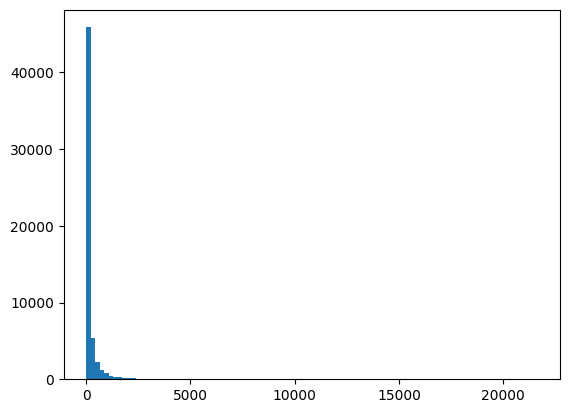

In [7]:
article_lengths = [len(article) for article in tokenized_articles]
plt.hist(article_lengths, bins=100)
plt.show()

Find the number of articles with length higher than `SEQ_LEN`

In [8]:
long_articles = [article for article in tokenized_articles if len(article) > SEQ_LEN]

print(f"Total number of articles: {len(tokenized_articles)}")
print(f"Number of articles with length > {SEQ_LEN}: {len(long_articles)}")
print(f"Percentage of articles with length > {SEQ_LEN}: {len(long_articles) / len(tokenized_articles) * 100:.2f}%")

Total number of articles: 57729
Number of articles with length > 512: 5448
Percentage of articles with length > 512: 9.44%


Drop the long articles, as we barely posses the resources to complete half an epoch anyway 

In [9]:
def drop_long_articles(articles: list[str], seq_len: int) -> list[str]:
    return [article for article in articles if len(article) <= seq_len]


tokenized_articles = drop_long_articles(tokenized_articles, SEQ_LEN)

Pad articles

In [10]:
def pad_articles(articles: list[list[str]], seq_len: int) -> list[list[str]]:
    max_len = max([len(article) for article in articles])
    assert max_len <= seq_len
    
    padded_articles: list[str] = []
    for article in articles:
        while len(article) < max_len:
            article.append("<PAD>")
        padded_articles.append(article)
    
    return padded_articles


padded_articles = pad_articles(tokenized_articles, SEQ_LEN)


# TESTING
for article in padded_articles[:5]:
    print(article)
    print("-" * 100)

['اصالت', 'جوهر', 'در', 'زبان', 'شناسی', '(', 'Essentialism', 'in', 'linguistics', ')', 'اعتقاد', 'به', 'این', 'اصل', 'است', 'که', 'تمامی', 'مفاهیم', 'زبانی', 'را', 'بالاخره', 'روزی', 'به', 'طور', 'عینی', 'و', 'آفاقی', 'تعریف', 'خواهیم_کرد', '؛', 'هرچند', 'که', 'بشر', 'هنوز', 'توفیق', 'چندانی', 'در', 'این', 'مسیر', 'نداشته_است', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'

## Create vocabulary

In [11]:
def create_vocab(articles: list[list[str]], min_count: int) -> Tuple[dict[str, int], dict[int, str]]:
    all_words: list[str] = []
    for article in articles:
        all_words.extend(article)
    
    counter = Counter(all_words)
    known_words = {word for word, count in counter.items() if count >= min_count}
    
    word2id = {word: i for i, word in enumerate(known_words)}
    id2word = {i: word for i, word in enumerate(known_words)}
    
    word2id["<UNK>"] = len(word2id)
    id2word[len(id2word)] = "<UNK>"
    
    # DEBUG: This is a temporary hack
    if "<SOS>" not in word2id:
        word2id["<SOS>"] = len(word2id)
        id2word[len(id2word)] = "<SOS>"
    if "<EOS>" not in word2id:
        word2id["<EOS>"] = len(word2id)
        id2word[len(id2word)] = "<EOS>"
        
    return word2id, id2word


word2id, id2word = create_vocab(padded_articles, MIN_COUNT)

with open("word2id.pkl", "wb") as f:
    pickle.dump(word2id, f)

with open("id2word.pkl", "wb") as f:
    pickle.dump(id2word, f)


# TESTING
print(word2id["صبا"])
print(len(word2id))

15172
29052


## Replace rare words with <UNK>

In [12]:
def replace_rare_words(articles: list[list[str]], word2id: dict[str, int]) -> list[list[str]]:
    return [[word if word in word2id else "<UNK>" for word in article] for article in articles]


preprocessed_articles = replace_rare_words(padded_articles, word2id)

## Convert words to ids

In [13]:
def convert_to_ids(articles: list[str], word2id: dict[str, int]) -> list[list[int]]:
    return [[word2id[word] if word in word2id else word2id["<UNK>"] for word in article] for article in articles]


ids = convert_to_ids(padded_articles, word2id)

with open("ids.pkl", "wb") as f:
    pickle.dump(ids, f)


# TESTING
print(ids[:3])

[[2182, 23444, 19697, 3799, 1747, 25204, 29049, 15021, 29049, 27760, 26755, 18045, 12149, 13656, 17313, 23866, 2482, 20217, 9435, 20545, 16300, 11056, 18045, 19308, 5101, 20928, 29049, 8674, 29049, 21094, 86, 23866, 12842, 28642, 22101, 968, 19697, 12149, 5660, 28788, 16618, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 12096, 120

## Dataset

In [14]:
class WikiDataset(Dataset):
    def __init__(self, ids: list[list[int]]) -> None:
        self.ids = ids
    
    def __len__(self) -> int:
        return len(self.ids)
    
    def __getitem__(self, index: int) -> Tuple[torch.tensor, torch.tensor]:
        sequence = self.ids[index]
        x = torch.LongTensor(sequence[:-1])
        y = torch.LongTensor(sequence[1:])
        
        return x, y

# Model

In [15]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(start=0, end=max_len, step=1).float() # (max_len)
        div_term = 1/torch.tensor(10000.0)**(torch.arange(start=0, end=d_model, step=2).float() / d_model) # (d_model / 2)

        pe[:, 0::2] = torch.sin(position.unsqueeze(1) * div_term) 
        pe[:, 1::2] = torch.cos(position.unsqueeze(1) * div_term) 
        self.register_buffer('pe', pe) 

    def forward(self, word_embeddings: torch.Tensor):
        # word_embeddings: (batch_size, max_len, d_model)
        # pe: (max_len, d_model)
        return word_embeddings + self.pe[:word_embeddings.size(1), :].unsqueeze(0)


class MaskedSelfAttention(nn.Module): 
    def __init__(self, d_model: int):
        super().__init__()
        
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
    def forward(self, x: torch.tensor, mask: torch.tensor):
        # x: (batch_size, max_len, d_model)
        # mask: (max_len, max_len)
        queries = self.W_q(x) # (batch_size, max_len, d_model)
        keys = self.W_k(x) # (batch_size, max_len, d_model)
        values = self.W_v(x) # (batch_size, max_len, d_model)

        sims = torch.matmul(queries, keys.transpose(dim0=1, dim1=2)) # (batch_size, max_len, max_len)
        scaled_sims = sims / torch.tensor(keys.size(2)**0.5) # (batch_size, max_len, max_len)
        
        masked_sims = scaled_sims.masked_fill(mask=mask.unsqueeze(0), value=-1e9) # (batch_size, max_len, max_len)
        
        attention_scores = F.softmax(masked_sims, dim=2) # (batch_size, max_len, max_len)
        values = torch.matmul(attention_scores, values) # (batch_size, max_len, d_model)
        
        return values

    
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, max_len: int):
        super().__init__()
        
        self.word_embedding = nn.Embedding(vocab_size, d_model)     
        self.position_encoding = PositionEncoding(d_model, max_len)
        self.masked_self_attention = MaskedSelfAttention(d_model)
        self.fc_layer = nn.Linear(d_model, vocab_size)
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, token_ids: torch.LongTensor):
        word_embeddings = self.word_embedding.forward(token_ids)     
        position_encoded = self.position_encoding.forward(word_embeddings)
        
        mask = torch.tril(torch.ones((token_ids.size(dim=1), token_ids.size(dim=1))))
        mask = mask.to(position_encoded.device)
        mask = mask == 0
        
        self_attention_values = self.masked_self_attention(position_encoded, mask=mask)
                
        residual_connection_values = position_encoded + self_attention_values       
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output

# Training, Evaluation, and Generation

## Training

## Train

In [16]:
with open("word2id.pkl", "rb") as f:
    word2id = pickle.load(f)

with open("id2word.pkl", "rb") as f:
    id2word = pickle.load(f)

with open("ids.pkl", "rb") as f:
    ids = pickle.load(f)
    random.shuffle(ids)
    
train_size = int(len(ids) * 0.8)
train_ids = ids[:train_size]
test_ids = ids[train_size:]

train_dataset = WikiDataset(train_ids)
test_dataset = WikiDataset(test_ids)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = DecoderOnlyTransformer(vocab_size=len(word2id), d_model=D_MODEL, max_len=SEQ_LEN).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=word2id["<PAD>"])
optimizer = AdamW(model.parameters(), lr=1e-3)

model.train()
losses: list[float] = []
ppxs: list[float] = []
for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch}")
    pbar = tqdm(train_loader)

    for x, y in pbar:
        x = x.to(DEVICE) # (batch_size, seq_len)
        y = y.to(DEVICE) # (batch_size, seq_len)
        
        y_logits = model.forward(x) # (batch_size, seq_len, vocab_size)
        
        loss = criterion(y_logits.view(-1, y_logits.shape[-1]), y.view(-1))
        ppx = perplexity(y_logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        ppxs.append(ppx.item())
        pbar.set_postfix(loss=loss.item(), ppx=ppx.item())
        
torch.save(model.state_dict(), "model.pt")

Epoch: 0


100%|██████████| 1307/1307 [02:05<00:00, 10.42it/s, loss=5.25, ppx=8.21e+5]


## Evaluate

In [17]:
model.eval()
with torch.no_grad():
    x, y = next(iter(test_loader))
    x = x.to(DEVICE) # (batch_size, seq_len)
    y = y.to(DEVICE) # (batch_size, seq_len)

    y_logits = model.forward(x) # (batch_size, seq_len, vocab_size)

    y_preds = y_logits.argmax(dim=-1) # (batch_size, seq_len)
    sentences_pred = [" ".join([id2word[idx.item()] for idx in seq_pred]) for seq_pred in y_preds]
    sentences_target = [" ".join([id2word[idx.item()] for idx in seq_target]) for seq_target in y]

    ppx = perplexity(y_logits, y)
    rouge = rouge_score(sentences_pred, sentences_target, accumulate="avg")
    
    print(f"perplexity: {ppx}")
    print(f"rouge: {rouge}")

perplexity: 664987.3125
rouge: {'rouge1_fmeasure': tensor(0.0568), 'rouge1_precision': tensor(0.0936), 'rouge1_recall': tensor(0.0568), 'rouge2_fmeasure': tensor(0.0424), 'rouge2_precision': tensor(0.0660), 'rouge2_recall': tensor(0.0436), 'rougeL_fmeasure': tensor(0.0525), 'rougeL_precision': tensor(0.0883), 'rougeL_recall': tensor(0.0520), 'rougeLsum_fmeasure': tensor(0.0565), 'rougeLsum_precision': tensor(0.0929), 'rougeLsum_recall': tensor(0.0566)}


## Generation

In [26]:
prompt = torch.LongTensor([word2id["<SOS>"], word2id["صبا"]]).to(DEVICE)
prompt_length = len(prompt)

predictions = model.forward(prompt.unsqueeze(0)).squeeze() 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])]).to(DEVICE)
predicted_ids = predicted_id

for i in range(prompt_length, SEQ_LEN):
    if (predicted_id == word2id["<EOS>"]):
        break
    
    prompt = torch.cat((prompt, predicted_id))
    
    predictions = model.forward(prompt.unsqueeze(0)).squeeze() 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])]).to(DEVICE)
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
print("Predicted Tokens:\n") 
for idx in predicted_ids: 
    print(id2word[idx.item()], end=" ")

Predicted Tokens:

( زاده NUM 4 ) NUM 4 ) NUM 4 ) بازیگر در گاهشماری هجری قمری ) بازیگر NUM 4 ) ، و در سال NUM 4 میلادی است . این سال NUM 4 میلادی است . جمعیت آن NUM 4 میلادی است . این شهر در سال NUM 4 در سال NUM 4 در سال NUM 4 میلادی است . این سال NUM 4 میلادی است . این سال NUM 2 درصد از NUM 4 در سال NUM 4 در سال NUM 4 میلادی است . این فیلم های NUM 2 درصد از NUM 4 میلادی است . این سال NUM 4 در سال NUM 4 در سال NUM 4 به عنوان NUM 2 میلیون NUM 2 اکتبر NUM 4 میلادی ) و NUM 4 میلادی است . این سال NUM 4 در سال NUM 4 در سال NUM 4 میلادی است . در سال NUM 2 نفر ( NUM 4 در سال NUM 4 تا NUM 4 میلادی است . این سال NUM 4 میلادی است . این سال NUM 2 متر مربع و NUM 4 میلادی ) ، جمعیت آن NUM 4 در سال NUM 4 در سال NUM 2 سالگی در سال NUM 4 میلادی ) و در سال NUM 2 متر در سال NUM 4 در سال NUM 4 میلادی است . این سال NUM 4 در سال NUM 4 در سال NUM 4 به عنوان سال NUM 4 به عنوان NUM 4 به صورت گرفته و NUM 4 به صورت گرفته و NUM 2 سال NUM 2 سالگی NUM 2 اکتبر NUM 4 میلادی است . این سال NUM 4 میلادی است . این سال 